# TP Integrador

Detección de anomalías en escáneres de rayos X de equipajes mediante aprendizaje profundo. El modelo identifica 5 objetos potencialmente peligrosos: pistola, cuchillo, alicates, tijeras y llave inglesa, lo que facilita la vigilancia inteligente en los sistemas de seguridad de los aeropuertos.

Data set: https://www.kaggle.com/datasets/orvile/x-ray-baggage-anomaly-detection/data

## Integrantes:
- Martin Paz
- Matias Tripode

## 1) Cargar el Dataset

In [3]:
!pip install torchmetrics
!pip install --upgrade --no-cache-dir gdown

# Clonar YOLOv5
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -r requirements.txt

%pip install albumentations opencv-python-headless


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

import torch
import torchvision
import torchsummary
import torchmetrics
from torch.utils.tensorboard import SummaryWriter

In [2]:
%cd /content/

/content


In [ ]:

# https://drive.google.com/file/d/19N6Q7qRJMzfro47SBCc0PY8pUXnPZOhI/view?usp=drive_link

# El ID sera: 19N6Q7qRJMzfro47SBCc0PY8pUXnPZOhI
!gdown --id 19N6Q7qRJMzfro47SBCc0PY8pUXnPZOhI

!unzip x-ray-baggage-anomaly-detection.zip > /dev/null

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=19N6Q7qRJMzfro47SBCc0PY8pUXnPZOhI
From (redirected): https://drive.google.com/uc?id=19N6Q7qRJMzfro47SBCc0PY8pUXnPZOhI&confirm=t&uuid=e46109ea-cd3c-438f-b6cf-b29f15c3e9e4
To: /content/x-ray-baggage-anomaly-detection.zip
100% 140M/140M [00:04<00:00, 34.3MB/s]


## 2) EDA

**Problema a resolver**
Detección y clasificación de objetos potencialmente peligrosos: pistola, cuchillo, alicates, tijeras y llave ingles en imagenes de scanner a equipajes en aeropuertos. Las métricas a utilizar deben considerar tanto la precisión de la clase como la localización del objeto (bounding box).


El analisis EDA se compone de los siguientes items:

1. Entendiento la estructura del dataset
2. Cuantas clases distintas tenemos?
3. Visualización preliminar de algunos los datos
4. Análisis de Distribución de Clases
5. Análisis del tamaño de las imágenes
6. Verificar si hay fotos sin etiquetas
7. Análisis de Bounding Boxes por clase
8. Ver la distribución de la relación porcentual entre los tamaños de los bounding box y las imágenes.
8. CONCLUSIONES


### 1). Entendiento la estructura del dataset

Primero vamos a entder la extractura del dataset. Vemos que tiene tres carpetas `test`, `train` y `valid`. Dentro de cada una tienen `images` and labels.
Como ejemplo:
```
train/
├── images/
│   └── 009000_jpg.rf.8c46e1aa5b46a0ad24ee4bcb2945d22a.jpg
└── labels/
    └── 009000_jpg.rf.8c46e1aa5b46a0ad24ee4bcb2945d22a.txt
```

Los archivos `labels` contienen una sola linea con formato:
 <class_id> <x_center> <y_center> <width> <height>

Ejemplo:

`2 0.6538461538461539 0.5420673076923077 0.0625 0.06610576923076923`





### 2). Cuantas clases distintas tenemos?

In [ ]:
def analyze_classes(labels_folder):
    class_ids = set()
    for label_file in os.listdir(labels_folder):
        with open(os.path.join(labels_folder, label_file), 'r') as f:
            for line in f:
                class_id = int(line.strip().split()[0])
                class_ids.add(class_id)

    print(f"Identificador de clase: {sorted(class_ids)}")
    return sorted(class_ids)

class_ids = analyze_classes('./train/labels')

Identificador de clase: [0, 1, 2, 3, 4]


Vemos que hay **5 clases** diferentes indicadas con numeros: `0, 1, 2, 3, 4`

### 3). Visualización preliminar de algunos los datos

Vamos a visualizar una imagen de cada clase, tomada al azar, del conjunto de entrenamiento. Esto es para tener nocion de como lucen las imágenes de nuestro set de datos. Esto nos ayudará a saber que tipos de transformaciones serán más útiles cuando realicemos data augmentation.

In [ ]:
import os
import cv2
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Configuración de paths
train_images_path = './train/images'
train_labels_path = './train/labels'

def graficar_ejemplos(train_images_path, train_labels_path):
  # Crear un diccionario para organizar las imágenes por clase
  class_images = {class_id: [] for class_id in range(5)}  # Asumiendo 5 clases (0-4)
  # Leer todas las imágenes y organizarlas por clase
  for label_file in os.listdir(train_labels_path):
      if not label_file.endswith('.txt'):
          continue

      # Obtener el path de la imagen correspondiente
      image_file = label_file.replace('.txt', '.jpg')
      image_path = os.path.join(train_images_path, image_file)

      # Leer las anotaciones y registrar todas las clases presentes
      with open(os.path.join(train_labels_path, label_file), 'r') as f:
          for line in f:
              class_id = int(line.strip().split()[0])
              if image_path not in class_images[class_id]:  # Evitar duplicados
                  class_images[class_id].append(image_path)

  # Configurar el gráfico
  plt.figure(figsize=(80, 65))

  # Para cada clase
  for class_id in sorted(class_images.keys()):
      # Tomar 4 imágenes aleatorias (o menos si no hay suficientes)
      sample_images = random.sample(class_images[class_id], min(4, len(class_images[class_id])))

      # Mostrar cada imagen
      for i, image_path in enumerate(sample_images):
          # Leer la imagen
          img = cv2.imread(image_path)
          img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
          height, width = img.shape[:2]

          # Configurar subplot
          ax = plt.subplot(5, 4, class_id*4 + i + 1)
          plt.imshow(img)
          plt.title(f'Clase {class_id}\n{os.path.basename(image_path)[:10]}...')
          plt.axis('off')

          # Leer el archivo de anotaciones y dibujar los bounding boxes
          label_path = image_path.replace('.jpg', '.txt').replace('images', 'labels')
          if os.path.exists(label_path):
              with open(label_path, 'r') as f:
                  for line in f:
                      parts = line.strip().split()
                      current_class = int(parts[0])

                      # Solo dibujar bounding boxes de la clase actual
                      if current_class == class_id:
                          x_center = float(parts[1]) * width
                          y_center = float(parts[2]) * height
                          box_width = float(parts[3]) * width
                          box_height = float(parts[4]) * height

                          # Calcular coordenadas del bounding box
                          x_min = x_center - (box_width / 2)
                          y_min = y_center - (box_height / 2)

                          # Crear el rectángulo
                          rect = patches.Rectangle(
                              (x_min, y_min), box_width, box_height,
                              linewidth=2, edgecolor='red', facecolor='none')
                          ax.add_patch(rect)
  plt.tight_layout()
  plt.suptitle('Ejemplos de Imágenes por Clase con Bounding Boxes', y=1.02, fontsize=16)
  plt.show()


graficar_ejemplos(train_images_path, train_labels_path)

### 4). Análisis de Distribución de Clases
Ahora vamos a analizar la distribución de clases. Esto nos puede ayudar a identificar posibles desbalances entre clases.

Distribución de clases:
Clase 0: 1284 instancias
Clase 1: 1393 instancias
Clase 2: 698 instancias
Clase 3: 1379 instancias
Clase 4: 1427 instancias
----


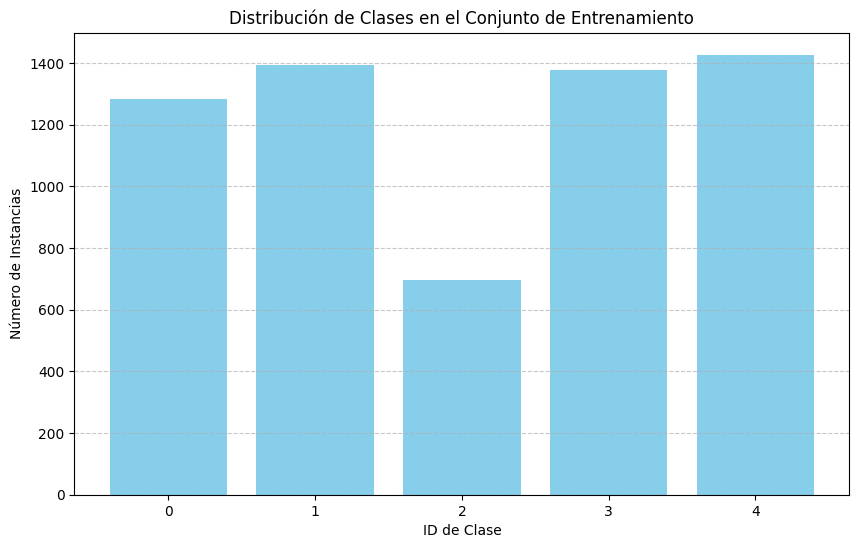

In [ ]:
import os
import matplotlib.pyplot as plt
from collections import Counter

def analizar_distribucion_clases(ruta_etiquetas):
    # Contador para almacenar la frecuencia de cada clase
    contador_clases = Counter()

    # Recorrer todos los archivos de etiquetas
    for archivo_etiqueta in os.listdir(ruta_etiquetas):
        ruta_completa = os.path.join(ruta_etiquetas, archivo_etiqueta)

        try:
            with open(ruta_completa, 'r') as f:
                for linea in f:
                    # Cada línea representa un objeto en la imagen
                    clase_id = int(linea.strip().split()[0])
                    contador_clases[clase_id] += 1
        except Exception as e:
            print(f"Error procesando {archivo_etiqueta}: {e}")

    return contador_clases

# Ruta a las etiquetas de entrenamiento
ruta_etiquetas_train = './train/labels'

# Obtener distribución de clases
distribucion = analizar_distribucion_clases(ruta_etiquetas_train)

# Mostrar resultados
print("Distribución de clases:")
for clase_id, conteo in sorted(distribucion.items()):
    print(f"Clase {clase_id}: {conteo} instancias")

print("----")
# Visualización
plt.figure(figsize=(10, 6))
plt.bar(distribucion.keys(), distribucion.values(), color='skyblue')
plt.title('Distribución de Clases en el Conjunto de Entrenamiento')
plt.xlabel('ID de Clase')
plt.ylabel('Número de Instancias')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Si conocemos los nombres de las clases, podemos personalizar los labels
# nombres_clases = {0: "Normal", 1: "Arma", 2: "Explosivo", ...}
# plt.xticks(list(nombres_clases.values()))

plt.show()

Vemos que Clase 2 tiene significativamente menos instancias (698) comparado con las demás. Las otras clases están relativamente balanceadas (1284-1427 instancias)

### 5). Análisis del tamaño de las imágenes

In [ ]:
import os
import cv2
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

def medir_las_fotos(carpeta_imagenes):
    print("Chequeando los tamaños de las fotos...")

    tamaños = defaultdict(int)
    problemas = []

    for archivo in os.listdir(carpeta_imagenes):
        try:
            # Leemos la imagen como si fuera un chori
            img = cv2.imread(os.path.join(carpeta_imagenes, archivo))
            if img is None:
                problemas.append(archivo)
                continue

            alto, ancho = img.shape[:2]
            tamaños[(ancho, alto)] += 1

        except Exception as e:
            print(f"Error con {archivo}: {e}")
            problemas.append(archivo)

    # Mostramos los resultados
    print("\nResumen de tamaños:")
    for tam, cant in sorted(tamaños.items()):
        print(f"Tamaño {tam}: {cant} fotos ({cant/len(os.listdir(carpeta_imagenes))*100:.1f}%)")

    if problemas:
        print(f"\n Error {len(problemas)} fotos (no se pudieron leer)")

    return tamaños, problemas

carpeta_train = './train/images'
tamaños, fotos_defectuosas = medir_las_fotos(carpeta_train)

Chequeando los tamaños de las fotos...

Resumen de tamaños:
Tamaño (416, 416): 6181 fotos (100.0%)


Vemos que todas las `6181` (1284 + 1393+ 698 + 1379+ 1427) fotos tienen el mismo tamaño ` (416, 416)`

### 6). Verificar si hay fotos sin etiquetas

In [ ]:
def comparar_con_y_sin_anotaciones(carpeta_imagenes, carpeta_etiquetas, ejemplos=5):
    print("\n Comparando fotos con y sin anotaciones...")

    # Buscamos fotos que tengan y no tengan anotaciones
    fotos_con_anotaciones = []
    fotos_sin_anotaciones = []

    todas_fotos = set(os.listdir(carpeta_imagenes))
    fotos_etiquetadas = set([f.replace('.txt', '.jpg') for f in os.listdir(carpeta_etiquetas)])

    fotos_sin_anotaciones = list(todas_fotos - fotos_etiquetadas)
    fotos_con_anotaciones = list(fotos_etiquetadas)

    print(f"Total fotos: {len(todas_fotos)}")
    print(f"Fotos con anotaciones: {len(fotos_con_anotaciones)}")
    print(f"Fotos sin anotaciones: {len(fotos_sin_anotaciones)}")

carpeta_etiquetas = './train/labels'
comparar_con_y_sin_anotaciones(carpeta_train, carpeta_etiquetas)


 Comparando fotos con y sin anotaciones...
Total fotos: 6181
Fotos con anotaciones: 6181
Fotos sin anotaciones: 0


Vemos que todas las fotos tienen sus etiquetas!

### 7) Análisis de Bounding Boxes por Clase

Con este análisis buscamos: Saber si hay características que nos pueda ayudar a distinguir objetos dependiendo de las clases.

Para cada clase y los bounding boxes queremos entender:

- Proporción de objetos pequeños (área del box < 1% del área de la imagen)
- Aspect ratios atípicos (ancho/alto < 0.2 o > 5.0)
- Promedio de objetos peligrosos por imagen

In [ ]:
from glob import glob
import os
from collections import defaultdict
import numpy as np

image_paths = sorted(glob('./train/images/*.jpg'))
label_paths = sorted(glob('./train/labels/*.txt'))

# Inicialización
small_object_threshold = 0.01  # 1%
aspect_ratio_threshold_low = 0.2
aspect_ratio_threshold_high = 5.0

class_stats = {
    i: {
        "total": 0,
        "small": 0,
        "weird_aspect_ratio": 0,
        "images": set()
    } for i in range(5)
}

# Total imágenes con al menos un objeto
images_with_objects = 0
total_objects = 0

for label_path in label_paths:
    with open(label_path, 'r') as f:
        lines = f.readlines()
        if not lines:
            continue  # sin objetos
        images_with_objects += 1

        for line in lines:
            try:
                class_id, x_c, y_c, w_box, h_box = map(float, line.strip().split())
                class_id = int(class_id)
            except:
                continue

            area = w_box * h_box
            aspect_ratio = w_box / h_box if h_box > 0 else 0

            class_stats[class_id]["total"] += 1
            total_objects += 1

            if area < small_object_threshold:
                class_stats[class_id]["small"] += 1

            if aspect_ratio < aspect_ratio_threshold_low or aspect_ratio > aspect_ratio_threshold_high:
                class_stats[class_id]["weird_aspect_ratio"] += 1

            # Registrar que esta clase aparece en esta imagen
            class_stats[class_id]["images"].add(label_path)

# Mostrar resultados
for class_id, stats in class_stats.items():
    total = stats["total"]
    if total == 0:
        print(f"Clase {class_id}: sin objetos etiquetados.\n")
        continue

    small_pct = 100 * stats["small"] / total
    weird_ar_pct = 100 * stats["weird_aspect_ratio"] / total
    avg_per_image = total / len(stats["images"])

    print(f"Clase {class_id}")
    print(f"- Total objetos: {total}")
    print(f"- % Objetos pequeños (<1%): {small_pct:.2f}%")
    print(f"- % Aspect ratio atípico: {weird_ar_pct:.2f}%")
    print(f"- Promedio objetos por imagen (con esa clase): {avg_per_image:.2f}")
    print()

print(f"Promedio general de objetos peligrosos por imagen: {total_objects / images_with_objects:.2f}")

7.1) Objetos pequeños (<1%)

La Clase 0 tiene solo 19.55% de objetos pequeños.
La Clase 1 tiene 80.62% de objetos pequeños.
La Clase 2 también es bastante alta: 67.91%.
La Clase 3 tiene solo 5.73% objetos pequeños.
La Clase 4 tiene 78.70% de objetos pequeños.
Conclusion Las clases 1, 2 y 4 tienen un alto porcentaje de objetos pequeños. Esto indicaría que deberíamos aplicar algún escalado que mejore la detección de objetos pequeños para estas clases.

7.2) Aspect ratios atípicos (<0.2 o >5) La Clase 2 destaca con 10.32% de aspect ratios extremos → tal vez herramientas largas o estrechas. El resto está bastante bajo, especialmente Clase 4: solo 0.21%.

Conclusion No vemos nada relevante que nos ayude a distinguir objetos de una clase dado aspect ratios atípicos.

7.3) Promedio de objetos por imagen = 1.00 Hay exactamente un solo objeto por imagen. `Conclusion** Solo tenemos que enfocarnos en detectar un elemento peligroso por imagen.

##8) Analizar la distribución de la relación porcentual entre los tamaños de los bounding box y las imágenes.


In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image
from collections import defaultdict

# Muestra histogramas del área relativa de los bounding boxes para cada clase.
def plot_bbox_size_distribution_by_class(labels_dir, images_dir, bins=30):
    class_relative_areas = defaultdict(list)

    for label_file in os.listdir(labels_dir):
        if not label_file.endswith('.txt'):
            continue

        label_path = os.path.join(labels_dir, label_file)
        image_path = os.path.join(images_dir, label_file.replace('.txt', '.jpg'))  # ajustá extensión si es necesario

        if not os.path.exists(image_path):
            print(f'Imagen no encontrada para {label_file}, se omite.')
            continue

        with open(label_path, 'r') as f:
            lines = f.readlines()

        if not lines:
            continue

        with Image.open(image_path) as img:
            img_width, img_height = img.size
            img_area = img_width * img_height

        for line in lines:
            parts = line.strip().split()
            if len(parts) != 5:
                continue

            class_id, x_center, y_center, width, height = map(float, parts)

            bbox_area = (width * img_width) * (height * img_height)
            relative_area = (bbox_area / img_area) * 100  # en porcentaje
            class_relative_areas[int(class_id)].append(relative_area)

    # Graficar histogramas
    num_classes = len(class_relative_areas)
    cols = 2
    rows = (num_classes + 1) // cols

    plt.figure(figsize=(12, 4 * rows))
    for idx, (class_id, areas) in enumerate(sorted(class_relative_areas.items())):
        plt.subplot(rows, cols, idx + 1)
        plt.hist(areas, bins=bins, color='skyblue', edgecolor='black')
        plt.title(f'Clase {class_id} - {len(areas)} bboxes')
        plt.xlabel('Área relativa (%)')
        plt.ylabel('Frecuencia')
        plt.grid(True)

    plt.tight_layout()
    plt.show()

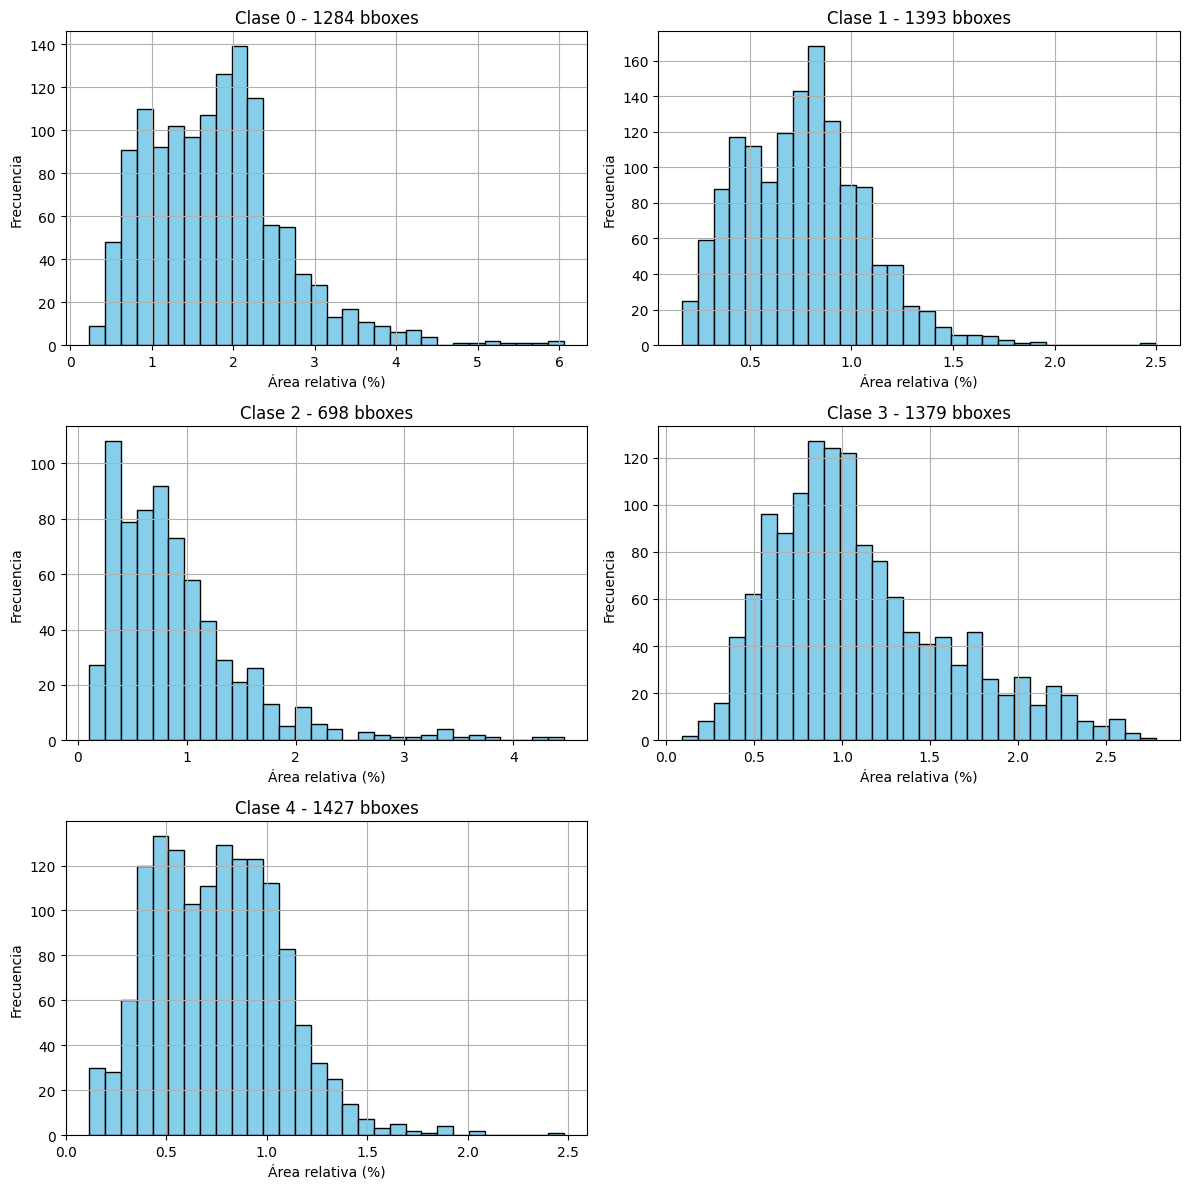

In [ ]:
labels_path = '/content/train/labels'
images_path = '/content/train/images'

plot_bbox_size_distribution_by_class(labels_path, images_path)

`Observaciones`:

Vemos que para todas las clases, la gran mayoria de los bounding boxes ocupan < 3% relativo al tamaño de la imagen

### 9). CONCLUSIONES

- `Distribución de las clases`: Vemos que Clase 2 tiene significativamente menos instancias (698) comparado con las demás. Las otras clases están relativamente balanceadas (1284-1427 instancias). Deberíamos aplicar data augmentation a la clase 2 para que no esté desbalanceada con respecto al resto de clases.
- `Tamaño de las imágenes`: Vemos que todas las 6181 imágenes tienen el mismo tamaño (416, 416)
- Aplicar un escalado para detectar objetos pequeños en las clases 1, 2 y 4.



--------------------------

## 3) Basedline YOLO5s y YOLO5m

Las dos arquitecturas elegidas para realizar el baseline son: `Yolo5s` y `Yolo5m`.

- Vamos a aumentar la clase dos llevandola al doble de imanges, esto va a balancearla con respecto a las otras clases.
- Vamos a ejecutar `50 epochs`.
- Por cada modelo y cada clase las `metricas` que vamos a considerar van a ser:
  - `mAP50` y `mAP50-95`
  - `Precision` y `Recall`



## YOLOv5

## Aplicar Augmentation solo a la clase 2

Vamos a realizar augmentation solo a la clase 2, ya que es la unica desbalanceada.
Realizaremos un augmentation por cada imagen eso nos llevara a balancearla con respecto al resto, quedan asi todas las clases con ~1200 imagenes cada una.

La augmentation aplicada es:
```
transform = A.Compose([
        A.HorizontalFlip(p=0.5), # Voltea la imagen horizontalmente (espejo).
        A.RandomScale(scale_limit=0.2, p=0.5), #  Escala la imagen aleatoriamente entre ±20% de su tamaño original.
        A.Rotate(limit=10, p=0.3), # Rota la imagen hasta ±10 grados.
        A.RandomBrightnessContrast(p=0.3), # Ajusta brillo y contraste aleatoriamente (30% de probabilidad).
        A.Resize(height=416, width=416), # Redimensiona la imagen a 416x416
    ], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))
```

In [ ]:
%cd /content/
!ls

/content
data.yaml	     sample_data  valid
README.dataset.txt   test	  x-ray-baggage-anomaly-detection.zip
README.roboflow.txt  train	  yolov5


In [ ]:
# Eliminar data aumentada
!rm -rf ./train_augmented/

In [ ]:
import os
import cv2
import albumentations as A
import shutil
import random
import numpy as np
from collections import defaultdict

# Augmentation transform (puedes ajustar según convenga)
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomScale(scale_limit=0.5, p=0.7),
    A.Rotate(limit=45, p=0.7),
    A.RandomBrightnessContrast(p=0.3),
    A.Resize(height=416, width=416),
    A.GridDropout(ratio=0.1, p=0.3),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

def get_class_from_label(label_path):
    with open(label_path, 'r') as f:
        lines = f.readlines()
    if not lines:
        return None
    classes = [int(line.strip().split()[0]) for line in lines]
    return classes[0] if all(c == classes[0] for c in classes) else None

def count_images_per_class(label_dir):
    class_counts = defaultdict(int)
    for filename in os.listdir(label_dir):
        if not filename.endswith('.txt'):
            continue
        label_path = os.path.join(label_dir, filename)
        cls = get_class_from_label(label_path)
        if cls is not None:
            class_counts[cls] += 1
    return class_counts

def augment_images_to_balance(image_dir, label_dir, output_img_dir, output_lbl_dir, target_per_class=2000):
    os.makedirs(output_img_dir, exist_ok=True)
    os.makedirs(output_lbl_dir, exist_ok=True)

    # Semilla para reproducibilidad
    seed = 42
    random.seed(seed)
    np.random.seed(seed)

    class_counts = count_images_per_class(label_dir)
    print("Imagenes por clase (original):", dict(class_counts))

    # Creamos un índice por clase para encontrar rápido las imágenes que se pueden aumentar
    class_to_files = defaultdict(list)
    for filename in os.listdir(label_dir):
        if not filename.endswith('.txt'):
            continue
        label_path = os.path.join(label_dir, filename)
        cls = get_class_from_label(label_path)
        if cls is not None:
            class_to_files[cls].append(filename)

    # Augmentamos solo las clases que tienen menos del objetivo
    for cls, current_count in class_counts.items():
        needed = target_per_class - current_count
        if needed <= 0:
            continue
        print(f"Augmentando clase {cls} para llegar a {target_per_class} (faltan {needed})")

        i = 0
        while i < needed:
            src_lbl_file = random.choice(class_to_files[cls])
            src_img_file = src_lbl_file.replace('.txt', '.jpg')
            img_path = os.path.join(image_dir, src_img_file)
            lbl_path = os.path.join(label_dir, src_lbl_file)

            if not os.path.exists(img_path) or not os.path.exists(lbl_path):
                continue

            with open(lbl_path, 'r') as f:
                lines = f.readlines()
            bboxes = [list(map(float, line.strip().split()[1:])) for line in lines]
            class_labels = [str(cls)] * len(bboxes)

            image = cv2.imread(img_path)
            if image is None:
                continue

            try:
                augmented = transform(image=image, bboxes=bboxes, class_labels=class_labels)
            except:
                print(f"Error augmenting {img_path}")
                continue

            new_img = augmented['image']
            new_bboxes = augmented['bboxes']

            # Nombre único
            new_img_name = src_img_file.replace('.jpg', f'_aug_{i}.jpg')
            new_lbl_name = src_lbl_file.replace('.txt', f'_aug_{i}.txt')

            cv2.imwrite(os.path.join(output_img_dir, new_img_name), new_img)
            with open(os.path.join(output_lbl_dir, new_lbl_name), 'w') as f:
                for box in new_bboxes:
                    f.write(f"{cls} {' '.join(map(str, box))}\n")

            i += 1

    print("Augmentation completo.")


In [ ]:
augment_images_to_balance(
    image_dir='/content/train/images/',
    label_dir='/content/train/labels/',
    output_img_dir='/content/train_augmented/images/',
    output_lbl_dir='/content/train_augmented/labels/'
)

Imagenes por clase (original): {1: 1393, 0: 1284, 2: 698, 3: 1379, 4: 1427}
Augmentando clase 1 para llegar a 2000 (faltan 607)
Augmentando clase 0 para llegar a 2000 (faltan 716)
Augmentando clase 2 para llegar a 2000 (faltan 1302)
Augmentando clase 3 para llegar a 2000 (faltan 621)
Augmentando clase 4 para llegar a 2000 (faltan 573)
Augmentation completo.


In [ ]:
%cd /content/



/content


In [ ]:
# COPIAR LAS IMAGENES AUTMENTADAS
!mv ./train_augmented/images/* ./train/images/
!mv ./train_augmented/labels/* ./train/labels/


## Graficar Imagenes aumentadas

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

# Ruta a tus imágenes y etiquetas aumentadas
aug_img_dir = '/content/train_augmented/images/'
aug_lbl_dir = '/content/train_augmented/labels/'

# Obtener los primeros 5 archivos de imagen
image_files = [f for f in os.listdir(aug_img_dir) if f.endswith('.jpg') or f.endswith('.png')][:3]

def plot_image_with_boxes(img_path, label_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape

    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f:
                cls, xc, yc, bw, bh = map(float, line.strip().split())
                # Convertir coordenadas normalizadas a píxeles
                x1 = int((xc - bw/2) * w)
                y1 = int((yc - bh/2) * h)
                x2 = int((xc + bw/2) * w)
                y2 = int((yc + bh/2) * h)
                cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
                cv2.putText(img, str(int(cls)), (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    return img

# Mostrar imágenes
plt.figure(figsize=(16, 10))
for idx, img_file in enumerate(image_files):
    img_path = os.path.join(aug_img_dir, img_file)
    label_path = os.path.join(aug_lbl_dir, img_file.replace('.jpg', '.txt').replace('.png', '.txt'))
    img = plot_image_with_boxes(img_path, label_path)
    plt.subplot(1, 3, idx+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(img_file[:15] + '...')
plt.tight_layout()
plt.show()


In [ ]:
!mv data.yaml ./yolov5

In [ ]:
%cd yolov5

/content/yolov5


In [ ]:
!ls

benchmarks.py	 data	    hubconf.py	    README.md	      train.py
CITATION.cff	 data.yaml  LICENSE	    README.zh-CN.md   tutorial.ipynb
classify	 detect.py  models	    requirements.txt  utils
CONTRIBUTING.md  export.py  pyproject.toml  segment	      val.py


### Justificación de la elección del baseline

El modelo seleccionado como baseline es **YOLOv5s**, ya que representa una arquitectura liviana y eficiente con un buen balance entre velocidad de entrenamiento/inferencia y precisión general. Esto lo hace ideal como punto de partida para comparar mejoras futuras, tanto en términos de arquitectura como de datos.

- YOLOv5s
 - Parámetros: 7M
 - mAP@0.5: 0.876
 - mAP@0.5:0.95: 0.381

Elegimos este modelo como baseline porque:
- Su tamaño reducido y bajo cómputo (15.8 GFLOPs) permiten realizar múltiples experimentaciones de forma ágil.
- Ya muestra un buen desempeño general (mAP50 cercano a 0.88), que sirve como piso para identificar mejoras reales.


### Ejecutar YOLO5s

In [ ]:
!python train.py \
  --img 416 \
  --batch 32 \
  --epochs 60 \
  --data data.yaml \
  --cfg models/yolov5s.yaml \
  --weights yolov5s.pt \
  --name yolov5s_augmented_all_classes_batch32_epoch50 \
  --cache

### Ejecutar YOLOR5m

In [ ]:
!python train.py \
  --img 416 \
  --batch 32 \
  --epochs 60 \
  --data data.yaml \
  --weights yolov5m.pt \
  --cfg models/yolov5m.yaml \
  --cache \
  --name yolov5m_augmented_all_classes_batch32_epoch60

--------------------------------------------------

### Evaluar Modelos

Evaluar `YOLO5m`

In [ ]:
!python val.py \
  --weights runs/train/yolov5m_augmented_clase2_batch32_epoch50_exp2/weights/best.pt \
  --data data.yaml \
  --img 416 \
  --task val

val: data=data.yaml, weights=['runs/train/yolov5m_augmented_clase2_batch32_epoch50_exp2/weights/best.pt'], batch_size=32, imgsz=416, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-422-g2540fd4c Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
YOLOv5m summary: 212 layers, 20869098 parameters, 0 gradients, 47.9 GFLOPs
val: Scanning /content/valid/labels.cache... 1766 images, 0 backgrounds, 0 corrupt: 100% 1766/1766 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 56/56 [00:19<00:00,  2.80it/s]
                   all       1766       1766      0.894      0.856      0.879      0.386
                     0       1766        391      0.978       0.98      0.981      0.507
     

Evaluar `YOLO5s`

In [ ]:
!python val.py \
  --weights runs/train/yolov5s_augmented_clase2_batch32_epoch50_v1/weights/best.pt \
  --data data.yaml \
  --img 416 \
  --task val

val: data=data.yaml, weights=['runs/train/yolov5s_augmented_clase2_batch32_epoch50_v1/weights/best.pt'], batch_size=32, imgsz=416, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-422-g2540fd4c Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7023610 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /content/valid/labels.cache... 1766 images, 0 backgrounds, 0 corrupt: 100% 1766/1766 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 56/56 [00:13<00:00,  4.00it/s]
                   all       1766       1766      0.871      0.836      0.858      0.368
                     0       1766        391      0.968      0.977      0.974      0.499
        

### TensorBoard: comparar gráficamente muchos experimentos

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs/train


### Ver Predicciones con Imagenes Reales

In [ ]:
%cd ./yolov5

/content/yolov5


In [ ]:
!python detect.py \
  --weights runs/train/yolov5m_augmented_clase2_batch32_epoch50_v1_1_50/weights/best.pt \
  --img 416 \
  --conf 0.25 \
  --source ../test/images

### Mostrar las primeras 5 imagenes con predicciones

In [ ]:
import os
from IPython.display import Image, display

# Muestra las primeras 5 imágenes con predicciones
for filename in os.listdir('runs/detect/exp3')[:50]:
    display(Image(filename=f"runs/detect/exp3/{filename}"))

### Funciones para copiar directorios y archivos desde y hace google-drive

In [5]:
def copy_directorio(source_path, destination_path):
  if not os.path.exists(destination_path):
        os.makedirs(destination_path)

  if os.path.exists(source_path):
      try:
        print(f"✔ Inicio copiado en: {destination_path}")
        shutil.copytree(source_path, destination_path, dirs_exist_ok=True) # copia directorios
        print(f"✔ Checkpoints guardados en: {destination_path}")
      except FileExistsError:
        print(f"No se encontró el directorio: {source_path}")
  else:
      print(f"No se encontró el directorio: {source_path}")

In [ ]:
def save_file(exp_name, source_path, destination_path):
  if not os.path.exists(destination_path):
        os.makedirs(destination_path)

  if os.path.exists(destination_path):

      shutil.copy2(os.path.join(source_path, exp_name), os.path.join(destination_path, exp_name)) # copia archivos
      print(f"Checkpoints guardados en: {destination_path}")
  else:
      print(f"No se encontró el directorio: {src_path}")

#### Obtener checkpoints desde Google Drive al Colab

#### Guardar experimentos en Google Drive

In [6]:
%cd /content/
!ls

/content
sample_data  yolov5


In [7]:
from google.colab import drive
import shutil
import os

# 1. Montar Google Drive
drive.mount('/content/drive')

# copiar experimento al drive
#copy_directorio('/content/yolov5/runs/train/yolov5l_augmented_todas_clases_batch32_epoch60', '/content/drive/MyDrive/yolov5_checkpoints/yolov5l_augmented_todas_clases_batch32_epoch60/')

copy_directorio('/content/drive/MyDrive/yolov5_checkpoints/yolov5l_augmented_todas_clases_batch32_epoch60/', '/content/yolov5/runs/train/yolov5l_augmented_todas_clases_batch32_epoch60')
copy_directorio('/content/drive/MyDrive/yolov5_checkpoints/yolov5m_augmented_all_classes_batch32_epoch60/', '/content/yolov5/runs/train/yolov5m_augmented_all_classes_batch32_epoch60')
copy_directorio('/content/drive/MyDrive/yolov5_checkpoints/yolov5s_augmented_all_classes_batch32_epoch50/', '/content/yolov5/runs/train/yolov5s_augmented_all_classes_batch32_epoch60')



Mounted at /content/drive
✔ Inicio copiado en: /content/yolov5/runs/train/yolov5l_augmented_todas_clases_batch32_epoch60
✔ Checkpoints guardados en: /content/yolov5/runs/train/yolov5l_augmented_todas_clases_batch32_epoch60
✔ Inicio copiado en: /content/yolov5/runs/train/yolov5m_augmented_all_classes_batch32_epoch60
✔ Checkpoints guardados en: /content/yolov5/runs/train/yolov5m_augmented_all_classes_batch32_epoch60
✔ Inicio copiado en: /content/yolov5/runs/train/yolov5s_augmented_all_classes_batch32_epoch60
✔ Checkpoints guardados en: /content/yolov5/runs/train/yolov5s_augmented_all_classes_batch32_epoch60


## Visualizar `Métricas Globales` para ambos modelos (mAP, precisión, etc.)

In [14]:
%cd yolov5
!ls

/content/yolov5
benchmarks.py	 data	     LICENSE	     README.zh-CN.md   train.py
CITATION.cff	 detect.py   models	     requirements.txt  tutorial.ipynb
classify	 export.py   pyproject.toml  runs	       utils
CONTRIBUTING.md  hubconf.py  README.md	     segment	       val.py


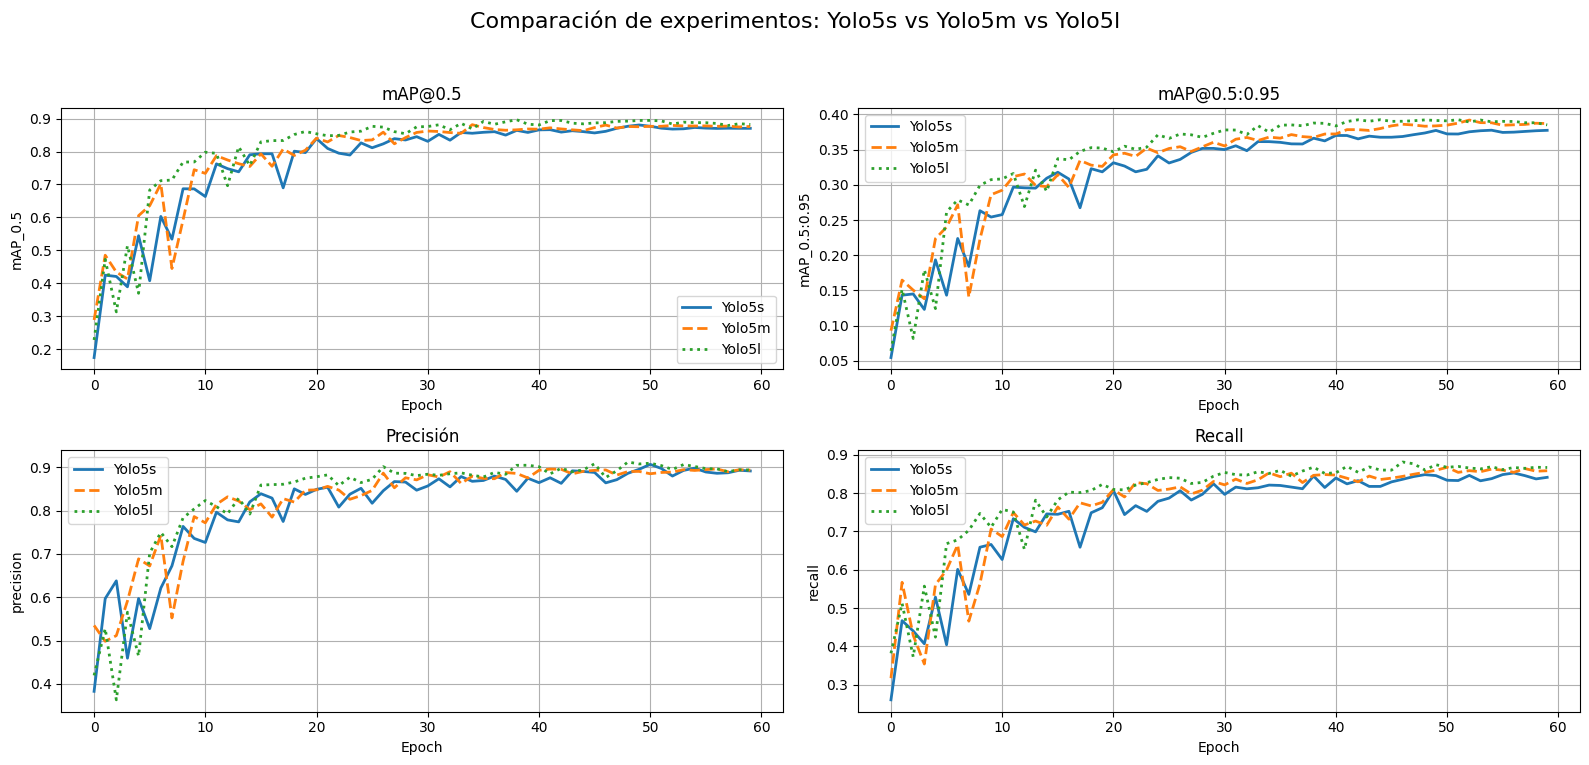

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

def comparar_experimentos(exp1, exp2, exp3):
    def cargar_resultados(exp):
        path = f'runs/train/{exp}/results.csv'
        df = pd.read_csv(path)
        df.columns = df.columns.str.strip()  # Limpiar espacios
        return df

    df1 = cargar_resultados(exp1)
    df2 = cargar_resultados(exp2)
    df3 = cargar_resultados(exp3)

    metrics = ['metrics/mAP_0.5', 'metrics/mAP_0.5:0.95', 'metrics/precision', 'metrics/recall']
    titulos = ['mAP@0.5', 'mAP@0.5:0.95', 'Precisión', 'Recall']

    plt.figure(figsize=(16, 8))
    for i, (metric, titulo) in enumerate(zip(metrics, titulos)):
        plt.subplot(2, 2, i + 1)
        plt.plot(df1[metric], label='Yolo5s', linewidth=2)
        plt.plot(df2[metric], label='Yolo5m', linewidth=2, linestyle='--')
        plt.plot(df3[metric], label='Yolo5l', linewidth=2, linestyle=':')
        plt.title(titulo)
        plt.xlabel('Epoch')
        plt.ylabel(metric.split('/')[-1])
        plt.grid(True)
        plt.legend()
    exp1_title = 'Yolo5s'
    exp2_title = 'Yolo5m'
    exp3_title = 'Yolo5l'

    plt.suptitle(f'Comparación de experimentos: {exp1_title} vs {exp2_title} vs {exp3_title}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

experiments = ['yolov5s_augmented_all_classes_batch32_epoch60', 'yolov5m_augmented_all_classes_batch32_epoch60', 'yolov5l_augmented_all_classes_batch32_epoch60']


comparar_experimentos(experiments[0], experiments[1], experiments[2])

### **Análisis Comparativo: YOLOv5m vs YOLOv5s**

#### **1. Métricas Globales**
| **Métrica**       | **YOLOv5m** | **YOLOv5s** | **Diferencia** |
|-------------------|-------------|-------------|----------------|
| **Precisión (P)** | 0.900       | 0.871       | +3.3% (m)      |
| **Recall (R)**    | 0.841       | 0.836       | +0.5% (m)      |
| **mAP@0.5**      | 0.875       | 0.858       | +1.7% (m)      |
| **mAP@0.5:0.95** | 0.384       | 0.368       | +4.3% (m)      |
| **Velocidad**     | 2.58 it/s   | 4.00 it/s   | +55% (s)       |

#### **Vemos que**
1. **YOLOv5m** supera a YOLOv5s en precisión (+3.3%) y mAP (+1.7-4.3%)
2. **YOLOv5s** es un 55% más rápido (4.00 it/s vs 2.58 it/s)
---

#### **2. Análisis Detallado por Clase**


**YOLOv5m**:

| Class | Images | Instances | P     | R     | mAP50 | mAP50-95 |
|-------|--------|-----------|-------|-------|-------|----------|
| all   | 1766   | 1766      | 0.900 | 0.841 | 0.875 | 0.384    |
| 0     | 1766   | 391       | 0.983 | 0.985 | 0.984 | 0.509    |
| 1     | 1766   | 389       | 0.909 | 0.900 | 0.908 | 0.376    |
| 2     | 1766   | 225       | 0.864 | 0.551 | 0.706 | 0.261    |
| 3     | 1766   | 366       | 0.814 | 0.844 | 0.847 | 0.382    |
| 4     | 1766   | 395       | 0.928 | 0.927 | 0.932 | 0.392    |

**YOLOv5s**:

| Class | Images | Instances | P     | R     | mAP50 | mAP50-95 |
|-------|--------|-----------|-------|-------|-------|----------|
| all   | 1766   | 1766      | 0.871 | 0.836 | 0.858 | 0.368    |
| 0     | 1766   | 391       | 0.968 | 0.977 | 0.974 | 0.499    |
| 1     | 1766   | 389       | 0.874 | 0.915 | 0.915 | 0.374    |
| 2     | 1766   | 225       | 0.779 | 0.565 | 0.653 | 0.236    |
| 3     | 1766   | 366       | 0.812 | 0.791 | 0.822 | 0.356    |
| 4     | 1766   | 395       | 0.919 | 0.929 | 0.923 | 0.377    |

---

#### **De las tablas vemos que**
1. **Clase 2** tiene bajo recall en ambos modelos (~55%)
2. **Clases 0 y 4** muestran excelente rendimiento en ambos modelos
3. **Clase 1** muestra `mAP50-95` bajo
4. **Clase 3** precisión baja (81%).

La clase de menor performance es la **Clase 2**
#### Haciendo double click en la **Clase 2**

| Métrica       | YOLOv5m | YOLOv5s | Diferencia |
|--------------|---------|---------|------------|
| Precisión (P) | 0.864   | 0.779   | +10.9%     |
| Recall (R)    | 0.551   | 0.565   | -2.5%      |
| mAP50        | 0.706   | 0.653   | +8.1%      |
| mAP50-95     | 0.261   | 0.236   | +10.6%     |

-------------------------------------

## Pasos Siguientes
- Determinar como podemos mejorar la performance de la **Clase 2**

Modifcando el augmentation para la **clase 2** con



Pasamos de ~A.RandomScale(scale_limit=0.2, p=0.5)~ a `A.RandomScale(scale_limit=0.5, p=0.7)`

~A.Rotate(limit=10, p=0.3)~ a `A.Rotate(limit=45, p=0.7)`
Y agregamos
`A.GridDropout(ratio=0.1, p=0.3)`

Quedando la agumentation para la clase 2 de:

```
 transform = A.Compose([
        A.HorizontalFlip(p=0.5), # Voltea la imagen horizontalmente (espejo).
        A.RandomScale(scale_limit=0.5, p=0.7), #  Escala la imagen aleatoriamente entre ±50% de su tamaño original.
        A.Rotate(limit=45, p=0.7), # Rota la imagen hasta ±45 grados.
        A.RandomBrightnessContrast(p=0.3), # Ajusta brillo y contraste aleatoriamente (30% de probabilidad).
        A.Resize(height=416, width=416), # Redimensiona la imagen a 416x416
        A.GridDropout(ratio=0.1, p=0.3),  # Oclusiones leves
    ], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

```
Obtenermos el siguiente resultado:

Vemos que la la `clase 2` mejora el `Recall` considerablemente (pero pierde un pequeño porcentaje en `Precision`) ver detalles a continuacion:

### **Rendimiento por Clase - YOLOv5m con Aumentación Mejorada**

### **Comparativa por Clase: Nuevo Experimento vs Baseline**

| **Clase** | **Métrica**   | **YOLOv5s** | **YOLOv5m** | **Diferencia** |
|-----------|---------------|---------------------|------------------------|----------------|
| **0**     | Precisión (P) | 0.983               | 0.978                  | -0.5%          |
|           | Recall (R)    | 0.985               | 0.980                  | -0.5%          |
|           | mAP50         | 0.984               | 0.981                  | -0.3%          |
| **1**     | Precisión (P) | 0.909               | 0.890                  | -2.1%          |
|           | Recall (R)    | 0.900               | 0.918                  | **+2.0%**      |
|           | mAP50         | 0.908               | 0.913                  | **+0.5%**      |
| **2**     | Precisión (P) | 0.864               | 0.830                  | -3.9%          |
|           | Recall (R)    | 0.551               | 0.629                  | **+14.2%**     |
|           | mAP50         | 0.706               | 0.719                  | **+1.8%**      |
| **3**     | Precisión (P) | 0.814               | 0.850                  | **+4.4%**      |
|           | Recall (R)    | 0.844               | 0.831                  | -1.5%          |
|           | mAP50         | 0.847               | 0.855                  | **+0.9%**      |
| **4**     | Precisión (P) | 0.928               | 0.920                  | -0.9%          |
|           | Recall (R)    | 0.927               | 0.929                  | +0.2%          |
|           | mAP50         | 0.932               | 0.924                  | -0.9%          |

**Conclusiones**
- Clase 2 (la más problemática):
  - **Recall mejoró +14.2%** (el avance más importante).
  - La **precisión disminuyo 3.9%** menos que en el primer experimento.

- `Clases estables (0 y 4)`:
  - Variaciones mínimas (<1%).

- Clase 1 y 3:
  - Mejoraron en recall y mAP50, pero con disminucion en precisión.



### Evaluar YOLO5L

In [ ]:
!python train.py \
  --img 416 \
  --batch 32 \
  --epochs 60 \
  --data data.yaml \
  --weights yolov5l.pt \
  --cfg models/yolov5l.yaml \
  --cache \
  --name yolov5l_augmented_todas_clases_batch32_epoch60

Streaming output truncated to the last 5000 lines.
      52/59      9.87G    0.03097   0.006161   0.002396         50        416:  10% 31/313 [00:16<02:32,  1.85it/s]/content/yolov5/train.py:414: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
      52/59      9.87G    0.03087   0.006156   0.002383         45        416:  10% 32/313 [00:17<02:34,  1.82it/s]/content/yolov5/train.py:414: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
      52/59      9.87G    0.03089   0.006189   0.002424         56        416:  11% 33/313 [00:17<02:31,  1.84it/s]/content/yolov5/train.py:414: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
      52/59      9.87G    0.03105 

### **Comparativa YOLOv5l vs YOLOv5m (Mejores Resultados)**

| **Clase** | **Métrica**   | **YOLOv5m** | **YOLOv5l** | **Diferencia** |
|-----------|---------------|--------------------|----------------------|----------------|
| **All**   | Precisión (P) | 0.894              | 0.879                | -1.7%          |
|           | Recall (R)    | 0.857              | 0.871                | **+1.6%**      |
|           | mAP50         | 0.878              | 0.886                | **+0.9%**      |
|           | mAP50-95      | 0.386              | 0.394                | **+2.1%**      |
| **0**     | mAP50         | 0.981              | 0.984                | **+0.3%**      |
| **1**     | mAP50         | 0.913              | 0.908                | -0.5%          |
| **2**     | mAP50         | 0.719              | 0.735                | **+2.2%**      |
| **3**     | mAP50         | 0.855              | 0.870                | **+1.8%**      |
| **4**     | mAP50         | 0.924              | 0.932                | **+0.9%**      |

**Conclusiones**:  

- Mejora en `Clase 2` (la más crítica):
  - mAP50: +2.2% (de 0.719 a 0.735).
  - Recall: +4.3% (de 0.629 a 0.656).

- Rendimiento Global:
  - mAP50-95: +2.1% (mejor ajuste de bboxes).
  - Recall: +1.6% (detecta más objetos en general).

`Velocidad vs Precisión`:
  - YOLOv5l es ~20% más lento (1.41 it/s vs 1.74 it/s de YOLOv5m).
  - Aceptable si la precisión es prioritaria.


-----------------

### Augmentation a todas las clases llevandolas a 2000 imagenes cada una

## Resultados de Entrenamiento - YOLOv5s (2000 imágenes por clase)

**Modelo:** YOLOv5s  
**Capas:** 157  
**Parámetros:** 7,023,610  
**GFLOPs:** 15.8  
**Épocas:** 50  
**Batch size:** 32  
**Ruta de resultados:** `runs/train/yolov5s_augmented_all_classes_batch32_epoch50_v1`

### 🔍 Métricas Generales

| Métrica   | Valor |
|-----------|-------|
| Precisión Promedio (P)      | 0.894 |
| Recall Promedio (R)         | 0.850 |
| mAP@0.5                     | 0.876 |
| mAP@0.5:0.95                | 0.381 |

### Desglose por Clase

| Clase | Instancias | P     | R     | mAP@0.5 | mAP@0.5:0.95 |
|-------|------------|-------|-------|---------|--------------|
| 0     | 391        | 0.974 | 0.982 | 0.982   | 0.506        |
| 1     | 389        | 0.910 | 0.907 | 0.920   | 0.384        |
| 2     | 225        | 0.814 | 0.624 | 0.684   | 0.247        |
| 3     | 366        | 0.837 | 0.801 | 0.843   | 0.374        |
| 4     | 395        | 0.932 | 0.937 | 0.951   | 0.397        |

---

### Observaciones

- Las clases **0**, **1**, y **4** muestran excelente desempeño con valores de `mAP@0.5` superiores a 0.9.
- La clase **2** sigue siendo la más desafiante:
  - Tiene el menor número de instancias.
  - También muestra la menor `recall` (0.624), lo que indica falsos negativos frecuentes.
- La métrica `mAP@0.5:0.95` sugiere que el modelo tiene margen de mejora en precisión de cajas.

---

### Recomendaciones

- Revisar y mejorar la calidad del etiquetado en la clase 2.
- Aumentar el número de imágenes de la clase 2 o aplicar más *data augmentation* específico.
- Probar modelos más robustos como `YOLOv5m` o `YOLOv5l` para mejorar `mAP@0.5:0.95`.



Ejecucion YOLO5m

YOLOv5m summary: 212 layers, 20869098 parameters, 0 gradients, 47.9 GFLOPs
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 28/28 [00:16<00:00,  1.71it/s]
                 
                   all       1766       1766      0.894      0.875      0.891      0.391
                     0       1766        391      0.979      0.982      0.983      0.522
                     1       1766        389      0.898      0.926       0.92      0.391
                     2       1766        225      0.833      0.693      0.749      0.262
                     3       1766        366      0.853      0.836      0.853      0.382
                     4       1766        395      0.908      0.937       0.95      0.397

# Comparación: YOLOv5s vs YOLOv5m (50 Epochs - 2000 imágenes por clase)

## Modelo

| Modelo   | Parámetros | GFLOPs |
|----------|-------------|--------|
| YOLOv5s  | 7.02M       | 15.8   |
| YOLOv5m  | 20.87M      | 47.9   |

---

## Métricas Generales

| Métrica         | YOLOv5s | YOLOv5m |
|-----------------|---------|---------|
| Precisión (P)   | 0.894   | 0.894   |
| Recall (R)      | 0.850   | 0.875   |
| mAP@0.5         | 0.876   | 0.891   |
| mAP@0.5:0.95    | 0.381   | 0.391   |

---

## Desempeño por Clase

| Clase | YOLOv5s P | YOLOv5s R | YOLOv5s mAP@0.5 | YOLOv5s mAP@0.5:0.95 | YOLOv5m P | YOLOv5m R | YOLOv5m mAP@0.5 | YOLOv5m mAP@0.5:0.95 |
|-------|-----------|-----------|------------------|----------------------|-----------|-----------|------------------|----------------------|
| 0     | 0.974     | 0.982     | 0.982            | 0.506                | 0.979     | 0.982     | 0.983            | 0.522                |
| 1     | 0.910     | 0.907     | 0.920            | 0.384                | 0.898     | 0.926     | 0.920            | 0.391                |
| 2     | 0.814     | 0.624     | 0.684            | 0.247                | 0.833     | 0.693     | 0.749            | 0.262                |
| 3     | 0.837     | 0.801     | 0.843            | 0.374                | 0.853     | 0.836     | 0.853            | 0.382                |
| 4     | 0.932     | 0.937     | 0.951            | 0.397                | 0.908     | 0.937     | 0.950            | 0.397                |

---

## Conclusiones

- **YOLOv5m** supera ligeramente a YOLOv5s en todas las métricas clave.
- **YOLOv5s** sigue siendo muy competitivo considerando que usa menos parámetros y cómputo.

---



### Ejecucion YOLO5L

YOLOv5l summary: 267 layers, 46129818 parameters, 0 gradients, 107.7 GFLOPs

                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 28/28 [00:20<00:00,  1.38it/s]
                   all       1766       1766      0.896      0.863      0.885       0.39
                     0       1766        391      0.989      0.985      0.981      0.511
                     1       1766        389      0.911      0.919      0.937      0.401
                     2       1766        225      0.816      0.631      0.703      0.249
                     3       1766        366      0.853      0.844      0.867      0.402
                     4       1766        395      0.909      0.934      0.935      0.385
Results saved to runs/train/yolov5l_augmented_todas_clases_batch32_epoch50_exp1

# Comparación: YOLOv5s vs YOLOv5m vs YOLOv5l  
50 Epochs - 2000 imágenes por clase

## Modelos

| Modelo   | Parámetros | GFLOPs |
|----------|------------|--------|
| YOLOv5s  | 7.02M      | 15.8   |
| YOLOv5m  | 20.87M     | 47.9   |
| YOLOv5l  | 46.13M     | 107.7  |

---

## Métricas Generales

| Métrica       | YOLOv5s | YOLOv5m | YOLOv5l |
|---------------|---------|---------|---------|
| Precisión (P) | 0.894   | 0.894   | 0.896   |
| Recall (R)    | 0.850   | 0.875   | 0.863   |
| mAP@0.5       | 0.876   | 0.891   | 0.885   |
| mAP@0.5:0.95  | 0.381   | 0.391   | 0.390   |

---

## Desempeño por Clase

| Clase | P (s) | R (s) | mAP50 (s) | mAP50-95 (s) | P (m) | R (m) | mAP50 (m) | mAP50-95 (m) | P (l) | R (l) | mAP50 (l) | mAP50-95 (l) |
|-------|-------|-------|------------|--------------|-------|-------|------------|--------------|-------|-------|------------|--------------|
| 0     | 0.974 | 0.982 | 0.982      | 0.506        | 0.979 | 0.982 | 0.983      | 0.522        | 0.989 | 0.985 | 0.981      | 0.511        |
| 1     | 0.910 | 0.907 | 0.920      | 0.384        | 0.898 | 0.926 | 0.920      | 0.391        | 0.911 | 0.919 | 0.937      | 0.401        |
| 2     | 0.814 | 0.624 | 0.684      | 0.247        | 0.833 | 0.693 | 0.749      | 0.262        | 0.816 | 0.631 | 0.703      | 0.249        |
| 3     | 0.837 | 0.801 | 0.843      | 0.374        | 0.853 | 0.836 | 0.853      | 0.382        | 0.853 | 0.844 | 0.867      | 0.402        |
| 4     | 0.932 | 0.937 | 0.951      | 0.397        | 0.908 | 0.937 | 0.950      | 0.397        | 0.909 | 0.934 | 0.935      | 0.385        |

---

## Conclusiones

- **YOLOv5l** ofrece una leve mejora en precisión y recall respecto a YOLOv5m, pero **el mAP@0.5:0.95 se mantiene prácticamente igual**.
- **YOLOv5m** parece ser el mejor compromiso entre precisión y costo computacional.
- **YOLOv5s** sigue siendo muy competitivo y eficiente, ideal para dispositivos con GPU limitada o despliegue en edge.



### Feedback de los profesores

> No alcanza con solo escalar el modelo (como pasar de YOLOv5m a YOLOv5l) si el modelo no está bien adaptado para captar objetos pequeños o detalles finos.
Debés considerar modelos multiescala, cambios en el campo receptivo y ajustes en los anclajes.


Basicamente pasar de YOLOv5s → YOLOv5m → YOLOv5l implica más capas, más parámetros y más capacidad. Pero eso no garantiza mejor rendimiento en clases con objetos pequeños. Que se ve claramente en los resultados de los experimentos.




# CONCLUSIONES FINALES DEL TP

- Este trabajo se buscó establecer un baseline realista con `YOLOv5s`, priorizando velocidad sobre optimizaciones avanzadas.
- Los resultados confirman que, efectivamente, escalar el modelo (utilizar `YOLOv5m` y `YOLOv5l`) no es suficiente para objetos pequeños, pero permitió cuantificar el trade-off entre costo y precisión.
- De hecho, nuestros resultados muestran que `YOLOv5l` sólo mejoró un `2.2%` en `mAP50` para la clase 2 (objetos pequeños) versus `YOLOv5m`, a costa de duplicar el tiempo de entrenamiento.
